In [7]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, is_step_enabled
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [9]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [10]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the dataset: (110527, 21)
Final columns in the dataset: Index(['Gender

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a...",-1,0,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ...",-1,0,1,1,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ...",-1,1,0,1,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...,-1,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...,-1,0,0,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.491979,0.603273,0.532594,0.106336,0.426412
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.499938,0.489221,0.498939,0.308269,0.494557
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis (EDA)

In this section, we perform exploratory data analysis on the patient appointments dataset to understand the data, visualize key features, and derive insights.

## Visualizations

Visualize the distribution of key features and their relationships.

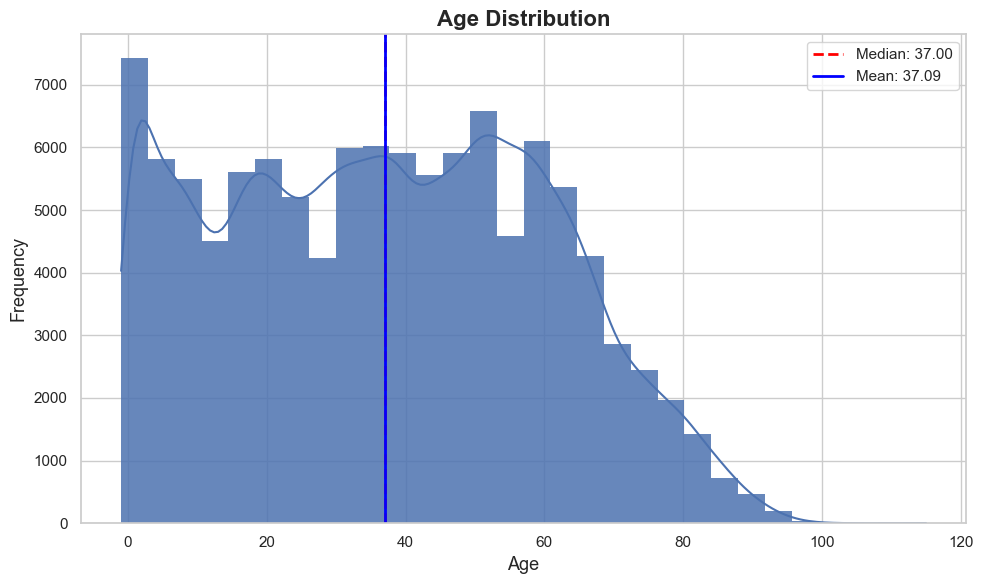

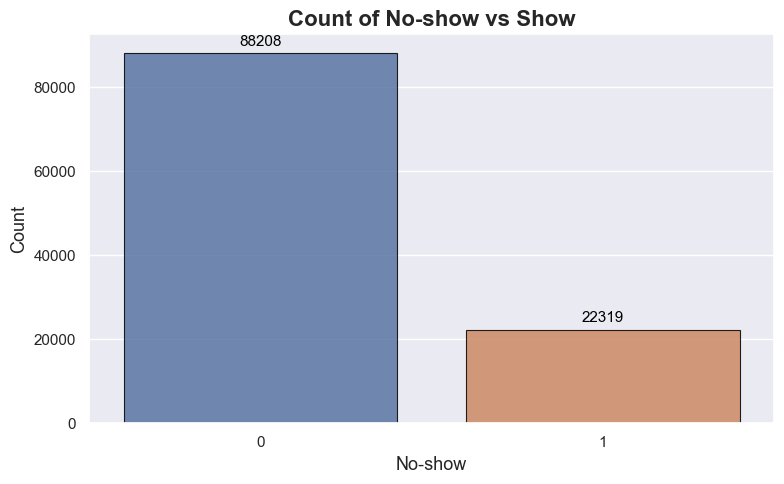

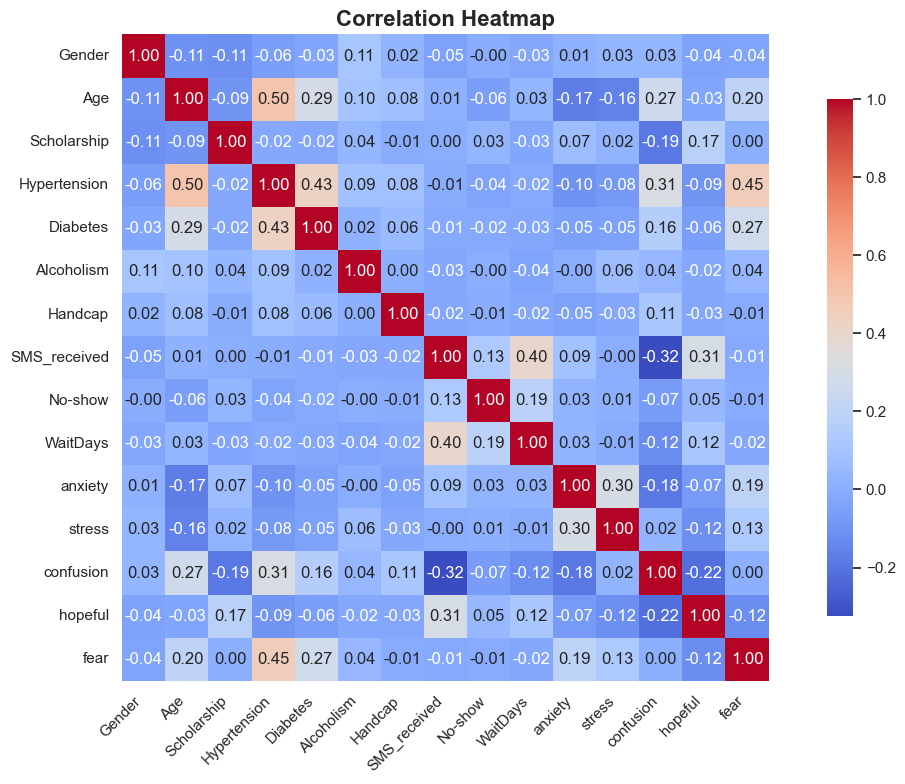

In [11]:
if is_step_enabled('eda'):
    # Distribution of Age - Using class-based approach
    plotter.plot_histplot(
        data=df,
        column='Age',
        bins=30,
        kde=True,
        title='Age Distribution',
        xlabel='Age',
        ylabel='Frequency',
        figsize=(10, 6)
    )

    # Countplot of No-show vs Show
    plotter.plot_countplot(
        data=df,
        column='No-show',
        title='Count of No-show vs Show',
        xlabel='No-show',
        ylabel='Count',
        figsize=(8, 5)
    )

    # Correlation heatmap 
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    plotter.plot_heatmap(
        data=correlation_matrix,
        title='Correlation Heatmap',
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        figsize=(12, 8)
    )

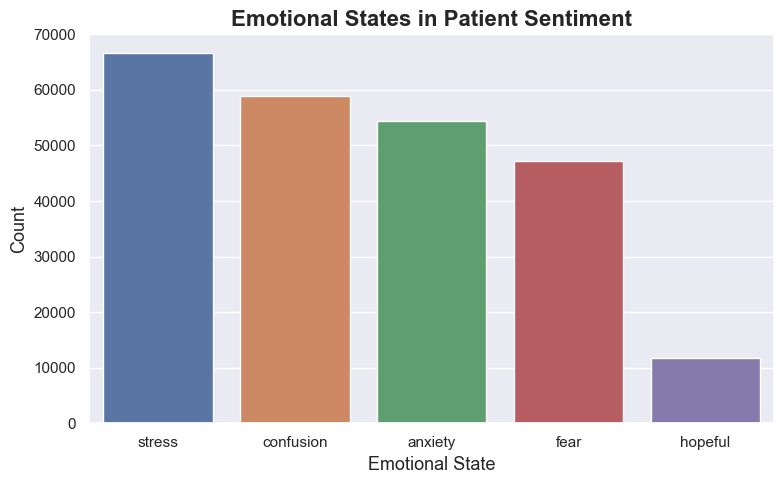

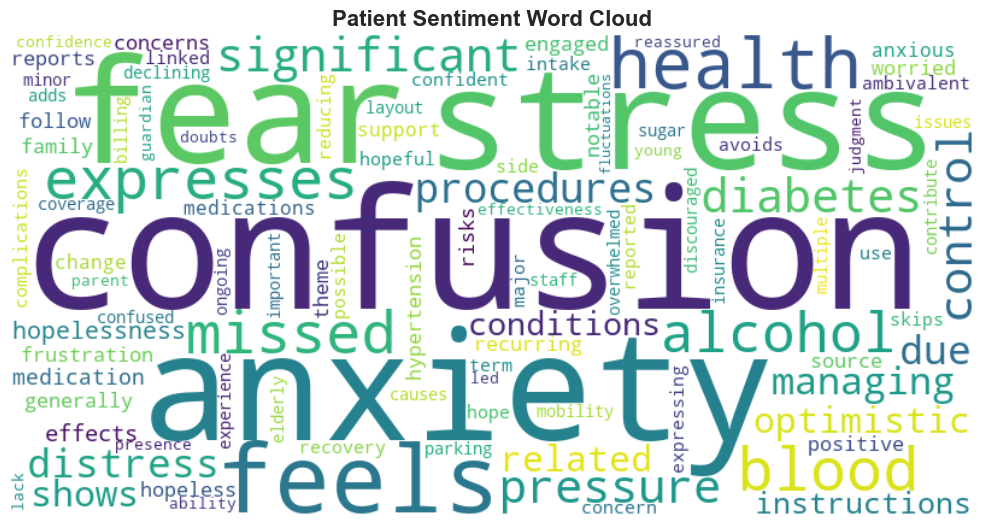

Total unique words after filtering: 161
Top 10 most frequent words: {'confusion': 77779, 'anxiety': 62099, 'fear': 57339, 'stress': 55610, 'feels': 54774, 'health': 50047, 'blood': 35628, 'expresses': 34563, 'missed': 33931, 'alcohol': 29663}


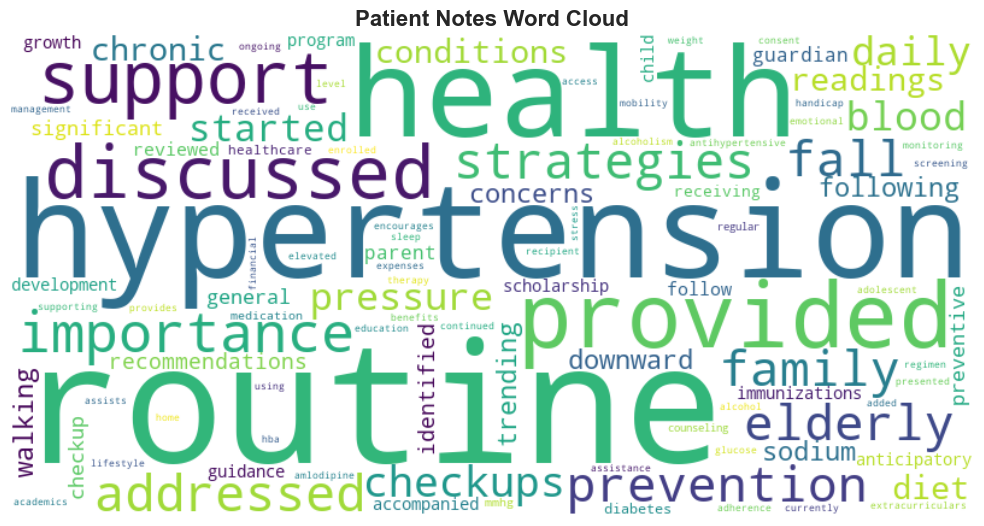

Total unique words after filtering: 480
Top 10 most frequent words: {'routine': 75106, 'hypertension': 69899, 'health': 62876, 'provided': 61365, 'discussed': 56894, 'support': 54154, 'importance': 45468, 'strategies': 43443, 'addressed': 43435, 'prevention': 43424}


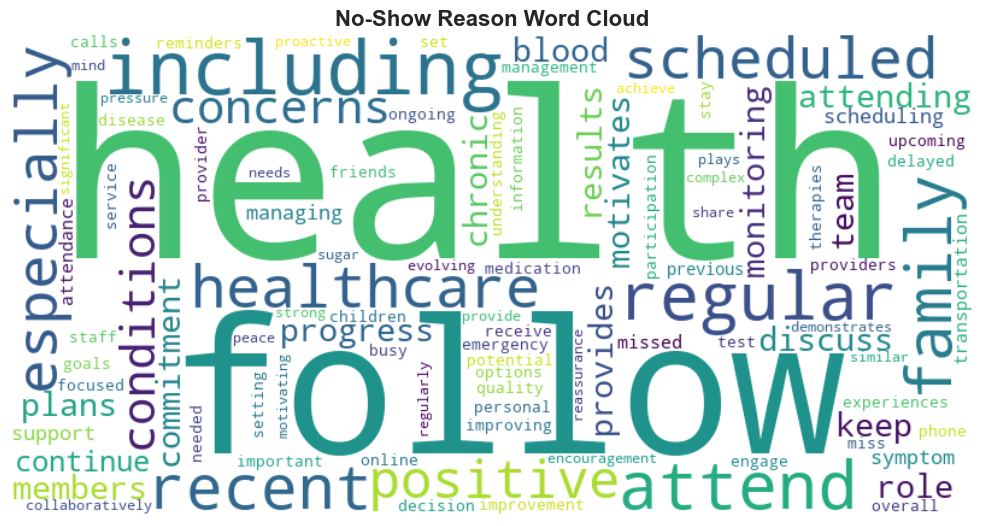

Total unique words after filtering: 477
Top 10 most frequent words: {'health': 35477, 'follow': 21074, 'including': 19948, 'attend': 15422, 'regular': 15302, 'family': 13660, 'recent': 13186, 'healthcare': 11945, 'especially': 11621, 'scheduled': 11592}


In [12]:
if is_step_enabled('eda'):
    # Plot emotional states as a bar plot - Using class method
    plotter.plot_emotional_states_bar(df)

    # Plot word clouds for PatientSentiment, PatientNotes, and NoShowReason
    plotter.plot_text_wordcloud(df['PatientSentiment'], title='Patient Sentiment Word Cloud')
    plotter.plot_text_wordcloud(df['PatientNotes'], title='Patient Notes Word Cloud')
    plotter.plot_text_wordcloud(df['NoShowReason'], title='No-Show Reason Word Cloud')

# Supervised Learning for Patient Show/No Show Prediction

Implement supervised learning algorithms to predict patient show/no-show.

# Unsupervised Learning

Apply unsupervised learning techniques to cluster patients.

## Unsupervised Learning Conclusion

K-Means and GMM clustering provided insights into patient groupings.

# NLP Analysis on Patient Appointments

Perform NLP analysis on patient notes and sentiments.

1. Patient Sentiment Analysis - TinyBert
1. Patient Notes Analysis -  ClinicalBERT
1. No Show Reason Analysis - DistillBERT

# Clinical Notes Analysis with TinyClinicalBERT
This section demonstrates clinical notes classification using TinyClinicalBERT. Steps include data loading, training, evaluation, and prediction.

# Patient Notes Clinical Analysis Workflow
This section covers model training, evaluation, metrics reporting, hyperparameter tuning, and model export for clinical notes using TinyClinicalBERT.

In [13]:
# if is_step_enabled('nlp_noshow_prediction'):
#     clinical_df = df[["PatientNotes", "PatientSentiment", "NoShowReason", "No-show"]]
#     clinical_df = clinical_df[clinical_df["No-show"].notna()]
#     clinical_df["NoShowReason"] = clinical_df["NoShowReason"].fillna("")
#     clinical_df["PatientSentiment"] = clinical_df["PatientSentiment"].fillna("")
#     clinical_df["PatientNotes"] = clinical_df["PatientNotes"].fillna("")
#     clinical_df["AssessmentNotes"] = clinical_df[['NoShowReason', 'PatientSentiment', 'PatientNotes']].agg(' '.join, axis=1)

In [14]:
# # Print counts of No-show and NoShowReason grouped
# grouped_counts = df.groupby(['No-show']).size().reset_index(name='count')
# print(grouped_counts)

In [15]:
# import pandas as pd
# import numpy as np
# import torch
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# from datasets import Dataset, DatasetDict
# from transformers import (
#     AutoTokenizer,
#     AutoModelForSequenceClassification,
#     TrainingArguments,
#     Trainer,
#     EarlyStoppingCallback,
# )
# from torch.nn.functional import softmax
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Check device (force CPU)
# device = torch.device("cpu")
# print(f"Using device: {device}")

# # --- Load and preprocess data ---
# df = df[["PatientNotes", "PatientSentiment", "NoShowReason", "No-show"]]
# df = df[df["No-show"].notna()]  # Ensure target present

# df["PatientNotes"] = df["PatientNotes"].fillna("")
# df["PatientSentiment"] = df["PatientSentiment"].fillna("")
# df["NoShowReason"] = df["NoShowReason"].fillna("")
# df["text"] = df["NoShowReason"] #+ " " + df["PatientSentiment"] + " " + df["PatientNotes"]
# df["label"] = df["No-show"].astype(int)

# # --- Split data ---
# train_texts, test_texts, train_labels, test_labels = train_test_split(
#     df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42, stratify=df["label"]
# )

# # --- Load tokenizer and model ---
# model_name = "nlpie/tiny-clinicalbert"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# # --- Convert to Hugging Face Dataset ---
# train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
# test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})
# dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# # --- Tokenization ---
# def tokenize_function(example):
#     return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

# tokenized_datasets = dataset.map(tokenize_function, batched=True)
# tokenized_datasets = tokenized_datasets.remove_columns(["text"])
# tokenized_datasets.set_format("torch")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return {
#         "eval_accuracy": accuracy_score(labels, predictions),
#         "eval_f1": f1_score(labels, predictions),
#         "eval_precision": precision_score(labels, predictions),
#         "eval_recall": recall_score(labels, predictions),
#     }

# # --- Training Arguments (CPU Optimized) ---
# training_args = TrainingArguments(
#                 output_dir="clinicalbert_model",
#                 no_cuda=True,
#                 use_cpu=True,
#                 per_device_train_batch_size=8,
#                 per_device_eval_batch_size=8 * 2,
#                 dataloader_num_workers=os.cpu_count(),
#                 eval_strategy="steps", 
#                 eval_steps=10,
#                 save_strategy="steps",
#                 save_steps=10,
#                 load_best_model_at_end=True,
#                 metric_for_best_model="f1",
#                 greater_is_better=True,
#                 save_total_limit=2,
#                 num_train_epochs=3,
#                 learning_rate=2e-5,
#                 logging_steps=10,
#                 remove_unused_columns=False,
#             )

# # --- Trainer with Early Stopping ---
# early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["test"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[early_stopping],
# )

# # --- Train model ---
# trainer.train()


In [16]:
# from sklearn.metrics import (
#     classification_report, confusion_matrix,
#     roc_curve, roc_auc_score, f1_score,
#     precision_score, recall_score
# )

# # === 6. Evaluate on Test Set ===
# pred_out = trainer.predict(tokenized_datasets["test"])
# logits = pred_out.predictions
# probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
# preds_05 = (probs >= 0.5).astype(int)
# true_labels = test_labels

# print("\n📊 Classification Report (threshold=0.5):")
# print(classification_report(true_labels, preds_05, zero_division=0))

# # Confusion matrix @ 0.5
# cm = confusion_matrix(true_labels, preds_05)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=["Show","No-Show"], yticklabels=["Show","No-Show"])
# plt.xlabel("Predicted"); plt.ylabel("Actual")
# plt.title("Confusion Matrix (threshold = 0.5)")
# plt.show()

# # ROC and AUC
# roc_auc = roc_auc_score(true_labels, probs)
# print(f"\n📈 ROC-AUC: {roc_auc:.3f}")
# fpr, tpr, _ = roc_curve(true_labels, probs)
# plt.figure(figsize=(5,4))
# plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
# plt.plot([0,1],[0,1],"k--")
# plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

# # === 7. Threshold Tuning ===
# best_f1, best_thresh = 0, 0.5
# print("\n🔍 Threshold Tuning:")
# for t in np.arange(0.1, 0.91, 0.05):
#     p = (probs >= t).astype(int)
#     f = f1_score(true_labels, p, zero_division=0)
#     pr = precision_score(true_labels, p, zero_division=0)
#     rc = recall_score(true_labels, p, zero_division=0)
#     print(f"Thresh {t:.2f} → F1={f:.3f}, Prec={pr:.3f}, Rec={rc:.3f}")
#     if f > best_f1:
#         best_f1, best_thresh = f, t
# print(f"\n✅ Best threshold: {best_thresh:.2f} (F1 = {best_f1:.3f})")

# # Confusion @ best threshold
# preds_best = (probs >= best_thresh).astype(int)
# print("\n📊 Classification Report (best threshold):")
# print(classification_report(true_labels, preds_best, zero_division=0))
# cm2 = confusion_matrix(true_labels, preds_best)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm2, annot=True, fmt="d", cmap="Purples",
#             xticklabels=["Show","No-Show"], yticklabels=["Show","No-Show"])
# plt.xlabel("Predicted"); plt.ylabel("Actual")
# plt.title(f"Confusion Matrix (threshold = {best_thresh:.2f})")
# plt.show()

In [17]:
# import random

# # === 8. Sample Predictions → Top Confidence ===
# print("\n--- Top 10 Confident Predictions ---")
# random_idxs = random.sample(range(len(test_texts)), 1000)
# inputs = tokenizer([test_texts[i] for i in random_idxs], padding=True, truncation=True, max_length=128, return_tensors="pt")
# with torch.no_grad():
#     out = model(**inputs)
# probs_full = torch.softmax(out.logits, dim=1).cpu().numpy()
# conf_scores = probs_full.max(axis=1)
# pred_classes = probs_full.argmax(axis=1)
# top_idxs = np.argsort(conf_scores)[-10:][::-1]

# for idx in top_idxs:
#     print(f"\nText: {test_texts[idx][:200]}...")
#     print(f"Actual: {'No-Show' if test_labels[idx]==1 else 'Show'}")
#     print(f"Predicted: {'No-Show' if pred_classes[idx]==1 else 'Show'} (Conf: {conf_scores[idx]:.2f})")

# Part II

In [18]:
import os, numpy as np, pandas as pd, torch, torch.nn as nn
import seaborn as sns, matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    auc, roc_auc_score, precision_recall_curve,
    precision_recall_fscore_support
)
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)

# Force CPU
device = torch.device("cpu")
print("Device:", device)

# 1️⃣ Load & Prepare Data
clinical_df = df[["PatientNotes", "PatientSentiment", "NoShowReason", "No-show"]].copy()
clinical_df = clinical_df.dropna(subset=["PatientNotes","PatientSentiment","NoShowReason","No-show"]).copy()
clinical_df["text"] = clinical_df["NoShowReason"] + " " + clinical_df["PatientNotes"] + " " + clinical_df["PatientSentiment"]
clinical_df["label"] = clinical_df["No-show"].astype(int)

dupe_count = clinical_df.duplicated(subset=["text"]).sum()
print("Number of duplicate text rows:", dupe_count)

# 2️⃣ Deduplicate to prevent leakage
print("Before deduplication:", len(clinical_df), "rows")
clinical_df = clinical_df.drop_duplicates(subset=["text"])
print("After deduplication:", len(clinical_df), "rows")

Device: cpu
Number of duplicate text rows: 20431
Before deduplication: 110527 rows
After deduplication: 90096 rows


In [19]:

# 3️⃣ Stratified train/test split
train_df, test_df = train_test_split(
    clinical_df, test_size=0.2, stratify=clinical_df["label"], random_state=42
)

# 4️⃣ Sanity check – no overlaps
overlap = set(train_df["text"]) & set(test_df["text"])
print("Overlap after split (should be 0):", len(overlap))
assert len(overlap) == 0

# 5️⃣ Prepare datasets
train_texts, train_labels = list(train_df["text"]), list(train_df["label"])
test_texts, test_labels = list(test_df["text"]), list(test_df["label"])

dataset = DatasetDict({
    "train": Dataset.from_dict({"text": train_texts, "label": train_labels}),
    "test": Dataset.from_dict({"text": test_texts, "label": test_labels})
})

# 6️⃣ Tokenization
tokenizer = AutoTokenizer.from_pretrained("nlpie/tiny-clinicalbert", use_fast=True)
def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
tokenized.set_format("torch")

# 7️⃣ Compute class weights for balanced loss
class_counts = np.bincount(train_labels)
class_weights = torch.tensor([len(train_labels)/c for c in class_counts], dtype=torch.float).to(device)
print("Class weights:", class_weights.numpy())

# 8️⃣ Define Trainer to use weighted loss
class WeightedLossTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(
        self, model, inputs, return_outputs=False, num_items_in_batch=None
    ):
        labels = inputs["labels"].to(model.device)
        outputs = model(
            input_ids=inputs["input_ids"].to(model.device),
            attention_mask=inputs["attention_mask"].to(model.device),
        )
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 9️⃣ Define compute_metrics (fixed unpacking)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    roc_auc = roc_auc_score(labels, probs)
    pr, rc, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(rc, pr)

    return {
        "accuracy": float((preds == labels).mean()),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "roc_auc": float(roc_auc),
        "pr_auc": float(pr_auc),
    }

# 🔟 Set up Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    "nlpie/tiny-clinicalbert", num_labels=2
)
training_args = TrainingArguments(
    output_dir="no_leakage_model",
    no_cuda=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    dataloader_num_workers=os.cpu_count(),
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="steps",
    save_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    num_train_epochs=5,
    learning_rate=2e-5,
    logging_steps=20,
    remove_unused_columns=False
)

trainer = WeightedLossTrainer(
    model=model,
    class_weights=class_weights,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 🧠 Train the model
trainer.train()
print("✅ Training completed.")

Overlap after split (should be 0): 0


Map:   0%|          | 0/72076 [00:00<?, ? examples/s]

Map:   0%|          | 0/18020 [00:00<?, ? examples/s]

Class weights: [1.3085932 4.240513 ]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Pr Auc
20,0.692300,0.690982,0.764151,0.000000,0.000000,0.000000,0.648484,0.385771
40,0.687600,0.689071,0.764151,0.000000,0.000000,0.000000,0.826925,0.668208
60,0.690200,0.682772,0.768590,1.000000,0.018824,0.036952,0.957749,0.893698
80,0.671400,0.647161,0.870366,1.000000,0.450353,0.621025,0.988198,0.963123
100,0.597000,0.482655,0.960655,0.875344,0.971529,0.920932,0.994545,0.982987
120,0.379500,0.266097,0.965483,0.904009,0.955059,0.928833,0.997669,0.993078


KeyboardInterrupt: 

In [ ]:
# 🔍 Evaluate on test set
pred_out = trainer.predict(tokenized["test"])
logits = pred_out.predictions
probs = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()
true = np.array(test_labels)

# 📊 Report at default threshold
preds_05 = (probs >= 0.5).astype(int)
print("\nClassification Report (thr=0.5):")
print(classification_report(true, preds_05, zero_division=0))

# 🔢 Confusion matrix
cm = confusion_matrix(true, preds_05)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Show","No-Show"], yticklabels=["Show","No-Show"])
plt.title("Confusion Matrix (thr=0.5)")
plt.show()

# 🧩 ROC & PR curves
fpr, tpr, _ = roc_curve(true, probs)
pr, rc, _ = precision_recall_curve(true, probs)
roc_auc = roc_auc_score(true, probs)
pr_auc = auc(rc, pr)
print(f"\nROC-AUC = {roc_auc:.3f}, PR-AUC = {pr_auc:.3f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rc, pr, label=f"PR = {pr_auc:.3f}")
plt.title("Precision–Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score
)

# 🎯 Threshold tuning
best_f1, best_thr = 0, 0.5
print("\nThreshold tuning:")
for t in np.arange(0.1, 0.91, 0.05):
    p = (probs >= t).astype(int)
    f = f1_score(true, p, zero_division=0)
    prc = precision_score(true, p, zero_division=0)
    rec = recall_score(true, p, zero_division=0)
    print(f"thr={t:.2f}: F1={f:.3f}, P={prc:.3f}, R={rec:.3f}")
    if f > best_f1:
        best_f1, best_thr = f, t
print(f"\nBest threshold: {best_thr:.2f} (F1={best_f1:.3f})")

preds_best = (probs >= best_thr).astype(int)
print("\nClassification Report (best thr):")
print(classification_report(true, preds_best, zero_division=0))

cm2 = confusion_matrix(true, preds_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Show","No-Show"], yticklabels=["Show","No-Show"])
plt.title(f"Confusion Matrix (thr={best_thr:.2f})")
plt.show()

In [ ]:
#Verify no overlap between train and test sets
set_train = set(train_texts)
set_test = set(test_texts)
print("Overlap:", len(set_train & set_test))  # Should be 0


## Skip This for now

In [ ]:
if is_step_enabled('nlp_noshow_prediction'):
    # Run the optimized model test
    !pytest -s ../tests/test_clinical_notes_prediction.py -k test_exported_clinicalbert_model  --maxfail=1 --disable-warnings -q